# 손실함수 (loss function)

## 이진분류 손실함수 Binary Cross Entropy

$$
\text{Loss} = -\left[y \cdot \log(p) + (1 - y) \cdot \log(1 - p)\right]
$$
- $y$: 실제 값 (0 또는 1)
- $p$: 예측 확률 (0과 1 사이)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 정답이 1: - log(p)
print('정답이 1, 손실크면: ', -np.log(0.2))
print('정답이 1, 손실작으면: ', -np.log(0.8))

# 정답이 0: - log(1 - p)
print('정답이 0, 손실작으면: ', -np.log(1 - 0.2))
print('정답이 0, 손실크면: ', -np.log(1 - 0.8))

정답이 1, 손실크면:  1.6094379124341003
정답이 1, 손실작으면:  0.2231435513142097
정답이 0, 손실작으면:  0.2231435513142097
정답이 0, 손실크면:  1.6094379124341005


In [6]:
# 직접 구현
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-8 # 0.00000001 로그에 0이 들어올수도 있으니 작은 값 넣음
    return - (y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))

y_true = np.array([1, 0, 1, 1])
y_pred = np.array([0.9, 0.1, 0.8, 0.7])

loss = binary_cross_entropy(y_true, y_pred)
loss

array([0.1053605 , 0.1053605 , 0.22314354, 0.35667493])

In [10]:
y_true = torch.tensor([1, 0, 1, 1], dtype=torch.float32)
y_pred = torch.tensor([0.9, 0.1, 0.8, 0.7])

criterion = nn.BCELoss()
loss = criterion(y_pred, y_true)
loss

tensor(0.1976)

In [11]:
# torch 손실함수 BCEWithLogitsLoss
# - 입력: logits
# - BCELoss 확률값이 0, 1에 가까우면, 수치계산 불안정, 이를 보완한 손실함수
logits = torch.tensor([2.173, -2.345, 1.386, -0.405], dtype=torch.float32) # 출력층 선형방정식 결과값
y_true = torch.tensor([1, 0, 1, 1], dtype=torch.float32)

# sigmoid + BCELoss
p = torch.sigmoid(logits)
criterion = nn.BCELoss()
loss = criterion(p, y_true)
print(loss)

# BCEWithLogitLoss
criterion2 = nn.BCEWithLogitsLoss()
loss = criterion2(logits, y_true)
print(loss)


tensor(0.3346)
tensor(0.3346)


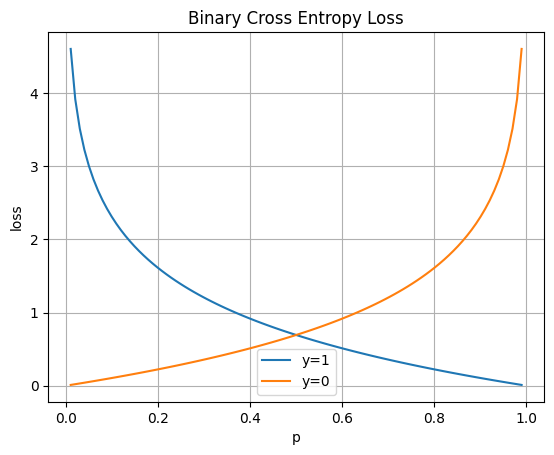

In [12]:
# 손실함수 시각화
p = np.linspace(0.01, 0.99, 100) # 시그모이드 통과한 확률값

loss_1 = -np.log(p)
loss_0 = -np.log(1 - p)

plt.plot(p, loss_1, label='y=1')
plt.plot(p, loss_0, label='y=0')

plt.title('Binary Cross Entropy Loss')
plt.xlabel('p')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

## 다중분류 손실함수 Cross Entropy
모델이 출력한 점수(logits)를 softmax 함수로 확률로 바꾼 뒤, 정답 클래스의 log 확률을 취한 값을 손실로 계산한다.

$$
\text{Loss} = -\log(\text{softmax}(\text{logits})[y])
$$

**수식 전체**

$$
\text{Loss} = -\log\left( \frac{e^{z_y}}{\sum_{j} e^{z_j}} \right)
$$

* $z = [z_0, z_1, ..., z_k]$: 각 클래스에 대한 모델의 출력값 (logits)
* $z_y$: 정답 클래스 $y$에 해당하는 로짓 값
* $\sum_j e^{z_j}$: 모든 클래스에 대한 softmax 분모

In [ ]:
# 직접 구현
y_true = 0
z = torch.tensor([2.0, 1.0, 0.1])
p = F.softmax(z, dim=0)
print(p)

pred = p.argmax(dim=0)
-np.log(p.numpy()[y_true])

tensor([0.6590, 0.2424, 0.0986])


np.float32(0.41702995)

In [16]:
# torch의 crossEntropyLoss
y_true = torch.tensor([0], dtype=torch.long) # long만 허용
z = torch.tensor([[2.0, 1.0, 0.10]]) # 배치 사이즈 때문에 [] 하나 더 감쌈

criterion = nn.CrossEntropyLoss()
loss = criterion(z, y_true) # pred값을 먼저 넣어야 함
print(loss.item())

0.4170299470424652


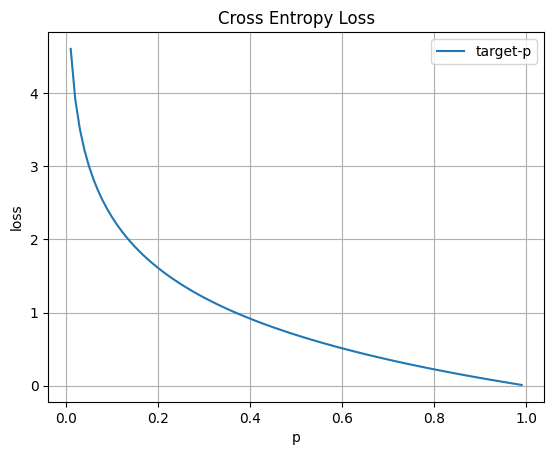

In [17]:
# 시각화
p = np.linspace(0.01, 0.99, 100)
loss = -np.log(p)
plt.plot(p, loss, label='target-p')
plt.title('Cross Entropy Loss')
plt.xlabel('p')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

## 회귀 손실함수

**1. MSELoss (Mean Squared Error Loss)**

**정의**: 오차(예측 - 실제)의 **제곱** 평균값을 계산

**특징**: 큰 오차에 더 큰 패널티 → 이상치에 민감

**수식**

$$
\text{MSELoss} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

**2. L1Loss 또는 MAELoss (Mean Absolute Error Loss)**

**정의**: 오차(예측 - 실제)의 **절댓값** 평균

**특징**: 이상치에 덜 민감하지만, 미분 불연속점 존재

**수식**

$$
\text{MAELoss} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$

**3. HuberLoss (Smooth L1 Loss)**

**정의**: 작은 오차에는 MSE처럼, 큰 오차에는 MAE처럼 동작

**특징**: 이상치에 덜 민감하면서도 미분 가능 → **타협형 손실함수**

**수식** (임계값 $\delta$를 기준으로 나뉨)

$$
\text{HuberLoss}(y_i, \hat{y}_i) =
\begin{cases}
\frac{1}{2}(y_i - \hat{y}_i)^2 & \text{if } |y_i - \hat{y}_i| \leq \delta \\
\delta \cdot \left( |y_i - \hat{y}_i| - \frac{1}{2}\delta \right) & \text{otherwise}
\end{cases}
$$

[ 0.5 -0.5 -0.1 -0.8 35.5 52.3]


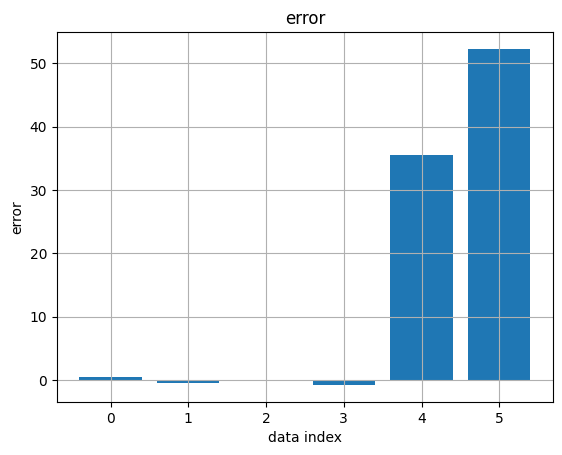

In [22]:
# 이상치가 없는 경우
# y_true = np.array([3.0, -0.5, 2.0, 7.0])
# y_pred - np.array([2.5, 0.0, 2.1, 7.8])


y_true = np.array([3.0, -0.5, 2.0, 7.0, 50.5, 60.0])
y_pred = np.array([2.5, 0.0, 2.1, 7.8, 15.0, 7.7])

error = y_true - y_pred
print(error)

plt.bar(range(len(y_true)), error)
plt.title('error')
plt.xlabel('data index')
plt.ylabel('error')
plt.grid()
plt.show()

In [23]:
# 손실함수별 비교
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))
def huber_loss(y_true, y_pred, delta=1.0):
    """
    delta보다 작은 오차엔 MSE
    delta보다 큰 오차엔 MAE
    """
    error = y_true - y_pred
    is_small_error = error <= delta
    return np.mean(np.where(is_small_error, 0.5 * (error ** 2), delta * (np.abs(error) - 0.5 * delta)))

y_true = np.array([3.0, -0.5, 2.0, 7.0, 50.5, 60.0])
y_pred = np.array([2.5, 0.0, 2.1, 7.8, 15.0, 7.7])

print('mse: ', mse(y_true, y_pred))
print('mae: ', mae(y_true, y_pred))
print('huber_loss: ', huber_loss(y_true, y_pred))

mse:  666.1149999999999
mae:  14.949999999999998
huber_loss:  14.5625


In [31]:
# torch 버전
y_true = torch.tensor([3.0, -0.5, 2.0, 7.0, 50.5, 60.0], dtype=torch.float32)
y_pred = torch.tensor([2.5, 0.0, 2.1, 7.8, 15.0, 7.7], dtype=torch.float32)

print('mse: ', F.mse_loss(y_true, y_pred))
print('mse (객체): ', nn.MSELoss()(y_true, y_pred)) # 객체로도 가능
print('mae (L1 loss): ', F.l1_loss(y_true, y_pred))
print('huber_loss: ', F.huber_loss(y_true, y_pred))
print('smooth_l1_loss: ', F.smooth_l1_loss(y_true, y_pred))



mse:  tensor(666.1150)
mse (객체):  tensor(666.1150)
mae (L1 loss):  tensor(14.9500)
huber_loss:  tensor(14.5625)
smooth_l1_loss:  tensor(14.5625)


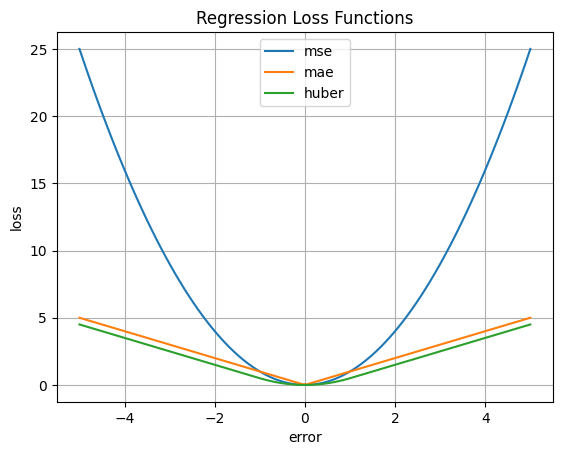

In [33]:
# 시각화
errors = torch.linspace(-5, 5, 100)

# 손실함수 객체
# reduction=mean 여러 오차를 평균내어 스칼라 반환
# reduction=none 여러 오차를 그대로 반환
mse_fn = nn.MSELoss(reduction='none') 
mae_fn = nn.L1Loss(reduction='none')  
huber_fn = nn.HuberLoss(reduction='none')


# 정답/예측
y_true = torch.zeros_like(errors)
y_pred = errors

# 손실계산
mse_loss = mse_fn(y_pred, y_true).numpy()
mae_loss = mae_fn(y_pred, y_true).numpy()
huber_loss = huber_fn(y_pred, y_true).numpy()
errors = errors.numpy()

# 시각화
plt.plot(errors, mse_loss, label='mse')
plt.plot(errors, mae_loss, label='mae')
plt.plot(errors, huber_loss, label='huber')

plt.title('Regression Loss Functions')
plt.legend()
plt.xlabel('error')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

### 신경망 모델에서 손실 함수 사용

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터 생성
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=2,
    random_state=42
)

# 전처리
scaler = StandardScaler()
X - scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


def one_hot(labels, num_classes):
    return np.eye(num_classes)[labels]

y_train_oh = one_hot(y_train, 2)
y_test-oh = one_hot(y_test, 2)
